# Notebook to Reproduce Originality Detection Findings

## Start Testground

```
$ testground daemon
```

## Run Testplans in Docker:
``` 
$ testground run single --plan=coopbc --testcase=bc --runner=local:docker --builder=docker:go --instances=10 --collect
```

### Run Testplans in K8S:
```
$ testground run single --plan=coopbc --testcase=bc --runner=cluster:k8s --builder=docker:go --instances=10 --collect --build-cfg go_proxy_mode=direct
```

# Parsing Outputs

### Find Output Dirs

In [16]:
import os

outputs_folder = "c6vhkft8gb1ak76ffd00"

docker_data_dir = "../outputs/local_docker/coopbc/"
directory_contents = os.listdir(docker_data_dir)
print(directory_contents)

['c709rd1mnbel377f6750', 'c708o21mnbel377f6610', 'c70h6k1mnbels0h14iag', 'c709if1mnbel377f66s0', 'c70i1l1mnbels0h14it0', 'c70au6hmnbel377f67jg', 'c70i2bhmnbels0h14itg', 'c70og29mnbei09a59vs0', 'c70fv8pmnbeqts4gcde0', 'c709rs1mnbel377f675g', 'c6vqk1t8gb164co63ip0', 'c708ichmnbel377f65rg', 'c70iolpmnbels0h14jd0', 'c70h9e1mnbels0h14icg', 'c70g88hmnbeqts4gcdn0', 'c6vpm6l8gb16rl0fi2sg', 'c70bd99mnbel377f6830', 'c7092spmnbel377f66c0', 'c70oco1mnbei09a59vog', 'c70ism1mnbels0h14jfg', 'c70b0hpmnbel377f67m0', 'c70ifh1mnbels0h14j6g', 'c708pf9mnbel377f662g', 'c709hh1mnbel377f66r0', 'c70av4pmnbel377f67kg', 'c70b9h1mnbel377f67v0', 'c709do9mnbel377f66n0', 'c70g8nhmnbeqts4gcdng', 'c70hq41mnbels0h14io0', 'c70bcq1mnbel377f682g', 'c708n3hmnbel377f6600', 'c7091upmnbel377f66b0', 'c7092dpmnbel377f66bg', 'c70fuppmnbeqts4gcddg', 'c6vq38l8gb1eb9thm2f0', 'c709fkhmnbel377f66p0', 'c709o41mnbel377f671g', 'c70g40hmnbeqts4gcdj0', 'c708hthmnbel377f65r0', 'c70o8gpmnbei09a59vk0', 'c70f2vpmnbeqts4gcchg', 'c70ao1hmnbel37

### Find all .out files and map them to their RUNID

In [17]:
import os
import pathlib
from pathlib import Path
import glob

def listdir_r(dirpath):
    paths=[]
    paths.append(dirpath)
    for path in os.listdir(dirpath):
        rpath = os.path.join(dirpath, path)
        if os.path.isdir(rpath):
            subdirs = listdir_r(rpath)
            if not subdirs == []:
                paths.extend(subdirs)
    return paths

all_paths_dict = {}
for d in directory_contents:
    # print(docker_data_dir + d)
    all_paths = listdir_r(os.path.abspath(docker_data_dir + d))
    all_paths_containing_target = [s for s in all_paths if d in s]
    all_paths_dict[d]=all_paths_containing_target

# print(all_paths_dict)

### Find target JSON Outputs in .out files 

In [18]:
def check_dir_for_target_lines(search_path):
    search_str = "___UploaderData___"
    file_type = ".out"
    target_line = []
    result = []
    targets = 13 # MAGIC NUMBER for the number of outputs - i should have parsed the whole file as json and just check the exact message instead of all strings
    success = False
    for fname in os.listdir(path=search_path):
        if fname.endswith(file_type):
                fo = open(search_path + "/" + fname)
                line = fo.readline()
                line_no = 1
                while line != '' :
                        index = line.find(search_str)
                        if ( index != -1) :
                            # print(fname, "[", line_no, ",", index, "] ", line, sep="")
                            success = True
                        line = fo.readline()
                        if success == True and targets > 0:
                            result.append(line)
                            targets -= 1
                        line_no += 1
                fo.close()
    return result

output_lines_dict_by_runid = {}
for d in directory_contents:
    output = []
    output_lines = []
    paths_containing_target = all_paths_dict[d]
    for pct in paths_containing_target:
        output = check_dir_for_target_lines(pct)
        if output:
            for l in output:
                # print(l)
                output_lines.append(l)
    output_lines_dict_by_runid[d]=output_lines

# print(output_lines_dict_by_runid)

### Parse Json Results to Data Frame

In [19]:
import json
import pandas as pd

#d = {'Instances': [], 'Latency': [], 'Bandwidth': [], 'Jitter': [], 'Loss': [], 'Corrupt': [], 'S2CheckDuration': [], 'OriginalityRatio': [], 'OriginalCombinations': [], 'DhtUploadDuration': [], 'DhtQueryDuration': []}


uber_data = [{}]
for runid in output_lines_dict_by_runid:
    kvs_dict = {}
    kvs_dict["RunID"] = runid
    for o in output_lines_dict_by_runid[runid]:
        m = json.loads(o)["event"]["message_event"]["message"]
        kv = m.split(": ", 1)
        if len(kv) > 1:
            kvs_dict[kv[0]] = kv[1]
    uber_data.append(kvs_dict)
uber_data.pop(0)
# print(uber_data)

my_data_frame = pd.DataFrame.from_dict(uber_data)
my_data_frame

,RunID,Instances,SimLatency_ms,SimPeerBandwidth_bps,SimJitter_ms,SimLoss_pct,SimCorrupt_pct,S2CheckDuration_s,OriginalityRatio_RO,UploadedOriginalCombinations,DhtUploadDuration_s,DhtQueryDuration_ms
0,c709rd1mnbel377f6750,75,10,1048576,0,0,0,5.741229284,0.7,14,6.386399097,58.361339
1,c708o21mnbel377f6610,15,10,1048576,0,0,0,5.558724019,0.7,14,6.039079855,11.537418
2,c70h6k1mnbels0h14iag,55,200,4096,30,20,10,6.618301349,0.7,14,7.258902318,20.146318
3,c709if1mnbel377f66s0,85,10,1048576,0,0,0,5.62728666,0.7,14,6.123075366,61.241072
4,c70i1l1mnbels0h14it0,40,200,4096,30,20,10,5.084343035,0.7,14,5.774172384,35.592741
...,...,...,...,...,...,...,...,...,...,...,...,...
491,c6vprrd8gb16rl0fi32g,95,80,1048576,5,1,1,4.993059658,0.7,14,5.317404278,37.52767
492,c70fcchmnbeqts4gccr0,40,130,65536,30,20,10,5.669268429,0.7,14,5.955565299,29.053626
493,c70ha4pmnbels0h14id0,80,200,4096,30,20,10,5.619607511,0.7,14,6.066996434,42.285496
494,c6vqesd8gb164co63ijg,25,80,1048576,5,1,1,6.174492461,0.7,14,6.484496868,26.513432


### S2 Check Duration

In [20]:
import matplotlib.pyplot as plt
import numpy as np

my_data_frame.Instances=pd.to_numeric(my_data_frame.Instances)
my_data_frame.S2CheckDuration_s=pd.to_numeric(my_data_frame.S2CheckDuration_s)
my_data_frame.DhtUploadDuration_s=pd.to_numeric(my_data_frame.DhtUploadDuration_s)
my_data_frame.DhtQueryDuration_ms=pd.to_numeric(my_data_frame.DhtQueryDuration_ms)
my_data_frame['DhtPutDuration_s'] = my_data_frame['DhtUploadDuration_s'] - my_data_frame['S2CheckDuration_s']

my_data_frame.SimLatency_ms=pd.to_numeric(my_data_frame.SimLatency_ms)
my_data_frame.SimJitter_ms=pd.to_numeric(my_data_frame.SimJitter_ms)
my_data_frame.SimPeerBandwidth_bps=pd.to_numeric(my_data_frame.SimPeerBandwidth_bps)
my_data_frame.SimLoss_pct=pd.to_numeric(my_data_frame.SimLoss_pct)
my_data_frame.SimCorrupt_pct=pd.to_numeric(my_data_frame.SimCorrupt_pct)

my_data_frame.sort_values(by=['Instances'])



,RunID,Instances,SimLatency_ms,SimPeerBandwidth_bps,SimJitter_ms,SimLoss_pct,SimCorrupt_pct,S2CheckDuration_s,OriginalityRatio_RO,UploadedOriginalCombinations,DhtUploadDuration_s,DhtQueryDuration_ms,DhtPutDuration_s
332,c70fsthmnbeqts4gcdbg,5,130,65536,30,20,10,5.723321,0.7,14,6.021971,5.008610,0.298650
466,c70ev7pmnbeqts4gccdg,5,130,65536,30,20,10,8.383197,0.7,14,8.800287,4.058685,0.417090
30,c708n3hmnbel377f6600,5,10,1048576,0,0,0,5.895302,0.7,14,6.172367,10.924504,0.277065
256,c6vq1rl8gb1eb9thm2dg,5,80,1048576,5,1,1,5.993785,0.7,14,6.337689,5.472035,0.343905
209,c70ais1mnbel377f6780,5,130,65536,30,2,2,5.780300,0.7,14,6.159643,4.300156,0.379344
...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,c70b5nhmnbel377f67rg,100,130,65536,30,2,2,5.862296,0.7,14,6.261316,48.994257,0.399020
44,c70gfshmnbeqts4gcdv0,100,130,65536,30,20,10,6.747858,0.7,14,7.402455,50.445873,0.654597
170,c709jshmnbel377f66tg,100,10,1048576,0,0,0,6.099687,0.7,14,6.524503,47.314015,0.424816
150,c70f859mnbeqts4gccn0,100,130,65536,30,20,10,6.059746,0.7,14,6.353988,40.301579,0.294242


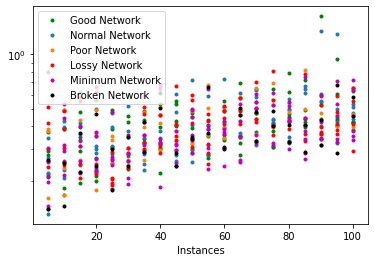

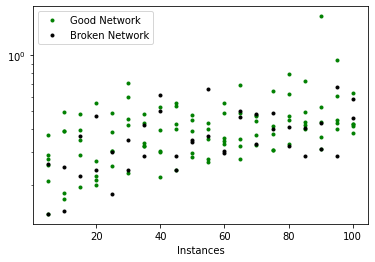

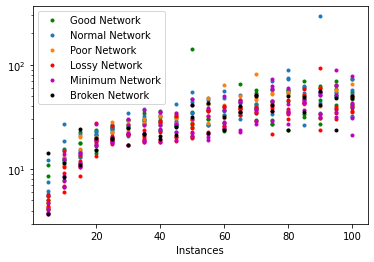

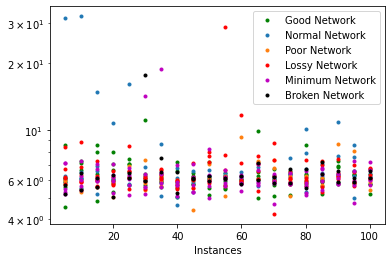

In [25]:
# Good Network but 1 Mebibyte Runs
rslt_df = my_data_frame[
    (my_data_frame['SimLatency_ms'] == 10) & 
    (my_data_frame['SimJitter_ms'] == 0) &
    (my_data_frame['SimPeerBandwidth_bps'] == 1048576) &
    (my_data_frame['SimLoss_pct'] == 0) &
    (my_data_frame['SimCorrupt_pct'] == 0)
    ]

# Default Network Run
rslt_df2 = my_data_frame[
    (my_data_frame['SimLatency_ms'] == 80) & 
    (my_data_frame['SimJitter_ms'] == 5) &
    (my_data_frame['SimPeerBandwidth_bps'] == 1048576) &
    (my_data_frame['SimLoss_pct'] == 1) &
    (my_data_frame['SimCorrupt_pct'] == 1)
    ]

# Poor Network Run
rslt_df3 = my_data_frame[
    (my_data_frame['SimLatency_ms'] == 130) & 
    (my_data_frame['SimJitter_ms'] == 30) &
    (my_data_frame['SimPeerBandwidth_bps'] == 65536) &
    (my_data_frame['SimLoss_pct'] == 2) &
    (my_data_frame['SimCorrupt_pct'] == 2)
    ]

# Lossy Network Run
rslt_df4 = my_data_frame[
    (my_data_frame['SimLatency_ms'] == 130) & 
    (my_data_frame['SimJitter_ms'] == 30) &
    (my_data_frame['SimPeerBandwidth_bps'] == 65536) &
    (my_data_frame['SimLoss_pct'] == 20) &
    (my_data_frame['SimCorrupt_pct'] == 10)
    ]

# Minimum Network Run
rslt_df5 = my_data_frame[
    (my_data_frame['SimLatency_ms'] == 200) & 
    (my_data_frame['SimJitter_ms'] == 30) &
    (my_data_frame['SimPeerBandwidth_bps'] == 4096) &
    (my_data_frame['SimLoss_pct'] == 20) &
    (my_data_frame['SimCorrupt_pct'] == 10)
    ]

# Broken Network Run
rslt_df6 = my_data_frame[
    (my_data_frame['SimLatency_ms'] == 300) & 
    (my_data_frame['SimJitter_ms'] == 60) &
    (my_data_frame['SimPeerBandwidth_bps'] == 64) &
    (my_data_frame['SimLoss_pct'] == 50) &
    (my_data_frame['SimCorrupt_pct'] == 20)
    ]

# K8s Runs

# Good Network but 1 Mebibyte Runs
rslt_df8 = my_data_frame[
    (my_data_frame['SimLatency_ms'] == 10) & 
    (my_data_frame['SimJitter_ms'] == 0) &
    (my_data_frame['SimPeerBandwidth_bps'] == 1048576) &
    (my_data_frame['SimLoss_pct'] == 0) &
    (my_data_frame['SimCorrupt_pct'] == 0)
    ]

# Default Network Run
rslt_df7 = my_data_frame[
    (my_data_frame['SimLatency_ms'] == 30) & 
    (my_data_frame['SimJitter_ms'] == 5) &
    (my_data_frame['SimPeerBandwidth_bps'] == 1048576) &
    (my_data_frame['SimLoss_pct'] == 1) &
    (my_data_frame['SimCorrupt_pct'] == 1)
    ]

# Poor Network Run
rslt_df3 = my_data_frame[
    (my_data_frame['SimLatency_ms'] == 130) & 
    (my_data_frame['SimJitter_ms'] == 30) &
    (my_data_frame['SimPeerBandwidth_bps'] == 65536) &
    (my_data_frame['SimLoss_pct'] == 2) &
    (my_data_frame['SimCorrupt_pct'] == 2)
    ]


# DHT PUTS
p1 = rslt_df.plot(x='Instances', y='DhtPutDuration_s', style='.',label='Good Network', color='g')
p2 = rslt_df2.plot(ax=p1, x='Instances', y='DhtPutDuration_s', style='.', label='Normal Network')
p3 = rslt_df3.plot(ax=p2, x='Instances', y='DhtPutDuration_s', style='.', label='Poor Network')
p4 = rslt_df4.plot(ax=p3, x='Instances', y='DhtPutDuration_s', style='.', label='Lossy Network', color="r")
p5 = rslt_df5.plot(ax=p4, x='Instances', y='DhtPutDuration_s', style='.', label='Minimum Network', color="m")
p6 = rslt_df6.plot(ax=p5, x='Instances', y='DhtPutDuration_s', style='.', label='Broken Network', color="k").set_yscale('log')

# DHT PUTS
p11 = rslt_df.plot(x='Instances', y='DhtPutDuration_s', style='.',label='Good Network', color='g')
p12 = rslt_df6.plot(ax=p11, x='Instances', y='DhtPutDuration_s', style='.', label='Broken Network', color="k").set_yscale('log')

# DHT GETS
p1 = rslt_df.plot(x='Instances', y='DhtQueryDuration_ms', style='.',label='Good Network', color='g')
p2 = rslt_df2.plot(ax=p1, x='Instances', y='DhtQueryDuration_ms', style='.', label='Normal Network')
p3 = rslt_df3.plot(ax=p2, x='Instances', y='DhtQueryDuration_ms', style='.', label='Poor Network')
p4 = rslt_df4.plot(ax=p3, x='Instances', y='DhtQueryDuration_ms', style='.', label='Lossy Network', color='r')
p5 = rslt_df5.plot(ax=p4, x='Instances', y='DhtQueryDuration_ms', style='.', label='Minimum Network', color="m")
p6 = rslt_df6.plot(ax=p5, x='Instances', y='DhtQueryDuration_ms', style='.', label='Broken Network', color="k").set_yscale('log')

# S2CheckDuration_s
p1 = rslt_df.plot(x='Instances', y='S2CheckDuration_s', style='.',label='Good Network', color='g')
p2 = rslt_df2.plot(ax=p1, x='Instances', y='S2CheckDuration_s', style='.', label='Normal Network')
p3 = rslt_df3.plot(ax=p2, x='Instances', y='S2CheckDuration_s', style='.', label='Poor Network')
p4 = rslt_df4.plot(ax=p3, x='Instances', y='S2CheckDuration_s', style='.', label='Lossy Network', color='r')
p5 = rslt_df5.plot(ax=p4, x='Instances', y='S2CheckDuration_s', style='.', label='Minimum Network', color="m")
p6 = rslt_df6.plot(ax=p5, x='Instances', y='S2CheckDuration_s', style='.', label='Broken Network', color="k").set_yscale('log')

<AxesSubplot:xlabel='Instances'>

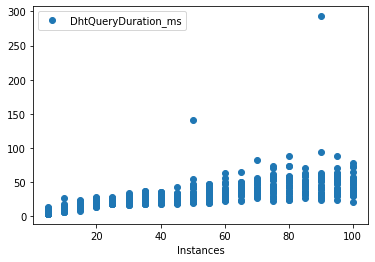

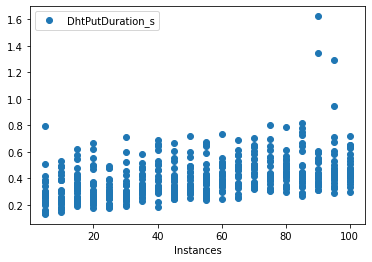

In [22]:



# my_data_frame.plot(x='Instances', y='DhtUploadDuration_s', style='o')
my_data_frame.plot(x='Instances', y='DhtQueryDuration_ms', style='o')


my_data_frame.plot(x='Instances', y='DhtPutDuration_s', style='o')

### Condition Figures from DataFrame

<AxesSubplot:xlabel='Instances'>

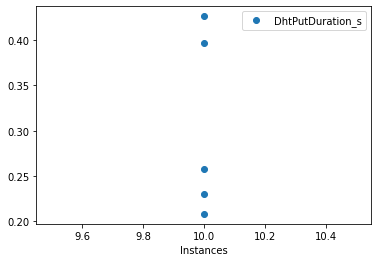

In [23]:
# selecting rows based on 

rslt_df = my_data_frame[(my_data_frame['Instances'] == 10) & (my_data_frame['SimJitter_ms'] == 5)]

rslt_df.plot(x='Instances', y='DhtPutDuration_s', style='o')

### Seaborn Plots

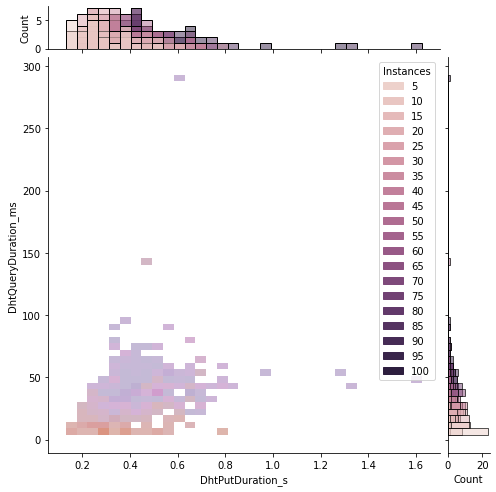

In [24]:
import seaborn as sns

sns.jointplot(data=my_data_frame, x="DhtPutDuration_s", y="DhtQueryDuration_ms", hue="Instances", kind="hist", height=7, ratio=8, marginal_ticks=True)